# Image Classification

## Table of Contents
* [1. Setup and Load Data](#setup)
    - [1.1 Install Depedencies and Setup](#install)
    - [1.2 Remove Nonimages](#remove)
    - [1.3 Load Data](#load)
* [2. Preprocess Data](#preprocess)
    - [2.1 Scale Data](#scale)
    - [2.2 Split Data](#split)
* [3. Deep Model](#deep_model)
    - [3.1 Build Deep Learning Model](#build_model)
    - [3.2 Train Model](#train)
    - [3.3 Plot Performance](#performance)
* [4. Evaluate Performance](#evaluation)
    - [4.1 Evaluate](#evaluate)
    - [4.2 Testing Multiple Images](#test_multi)
    - [4.3 Testing Single Images](#test_single)
* [5. Save Model](#saving_model)
    - [5.1 Saving the Model](#save)

## Notes
This is an image classification model with Deep Learning using tensorflow. This notebook is my first Deep Learning experience following this [tutorial](https://www.youtube.com/watch?v=jztwpsIzEGc). The tutorial uses images of happy and sad people, but I will be using images of objects and see if the model can identify each set of objects.

The data was collected from various search engines, and stored in a file called 'data' where we will separate the images in folders with their corresponding label. We start by setting up our GPU for usage and installing all dependencies. We remove any images that do not have an image extension and resizing all images to a consistent size. Data is preprocessed by scaling it down to make it easier to iterate and then split into training, validation and testing batches. We use a Sequential model and feed it the training batches. The model was successful when identifying two categories using the sigmoid activation function, but when adding more datasets the model's accuracy dropped to about 30%. I gave it more training cycles to see if the model just needed more training but it did not increase in accuracy.

Upon further reviewed I noticed that the pictures I was testing were going in as BGR because of OpenCV, when I had trained my data with RBG. After converting the testing data to RGB the model's classification increased to about 60-70%. When I tried using VGG16 model that had won awards for images classification the accuracy surprisingly dropped to about 30%. Leading me to believe that the model is too big for my datasets since it's only about 250 images per category and the model was made to classify 1000s of categories filled with 1000s of pictures. The recommended amount of images is 1000 per category so after downloading more images and cleaning them up manually my model's accuracy increased to about 90%.

# 1. Setup and Load Data <a id="setup"></a>

## 1.1 Install Dependencies and Setup <a id="install"></a>

In [ ]:
!pip install tensorflow==2.10 tensorflow-gpu==2.10 opencv-python matplotlib

In [ ]:
pip list

In [6]:
import tensorflow as tf
import os

In [7]:
## Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.2 Remove Nonimages <a id="remove"></a>

In [8]:
import cv2
import imghdr

In [9]:
data_dir = 'data'
image_extensions = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
def remove_nonimage(image):
    try:
        img = cv2.imread(image)
        extension = imghdr.what(image)

        if extension not in image_extensions:
            print('Image not in extension list {}'.format(image))
            os.remove(image)
    except Exception as e:
        print('Issue with image {}'.format(image))
        os.remove(image)

for image_class in os.listdir(os.path.join(data_dir, 'training')):
    for image in os.listdir(os.path.join(data_dir, 'training', image_class)):
        image_path = os.path.join(data_dir, 'training', image_class, image)
        remove_nonimage(image_path)

## 1.3 Load Data <a id="load"></a>

Loads images into a data image pipeline. The <span style="color:#5886e8">image_dataset_from_directory</span> transforms data into a consistent shape and batch.  
All images transform to size (256, 256).

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

- Pipeline can be reconfigured with  
<span style="color:#5886e8">image_dataset_from_directory('data', image_size=(#,#), batch_size = # )</span>

In [391]:
data = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'training'), batch_size = 15)
data = data.shuffle(buffer_size=2500, reshuffle_each_iteration= True)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

Found 3334 files belonging to 3 classes.


(15, 256, 256, 3)

<span style="color:#5886e8">batch</span> has 2 indexes the image and the class of the image (int)

In [392]:
class_names = np.array(os.listdir(os.path.join(data_dir, 'training')))
print(class_names)

['basketball' 'soccerball' 'volleyball']


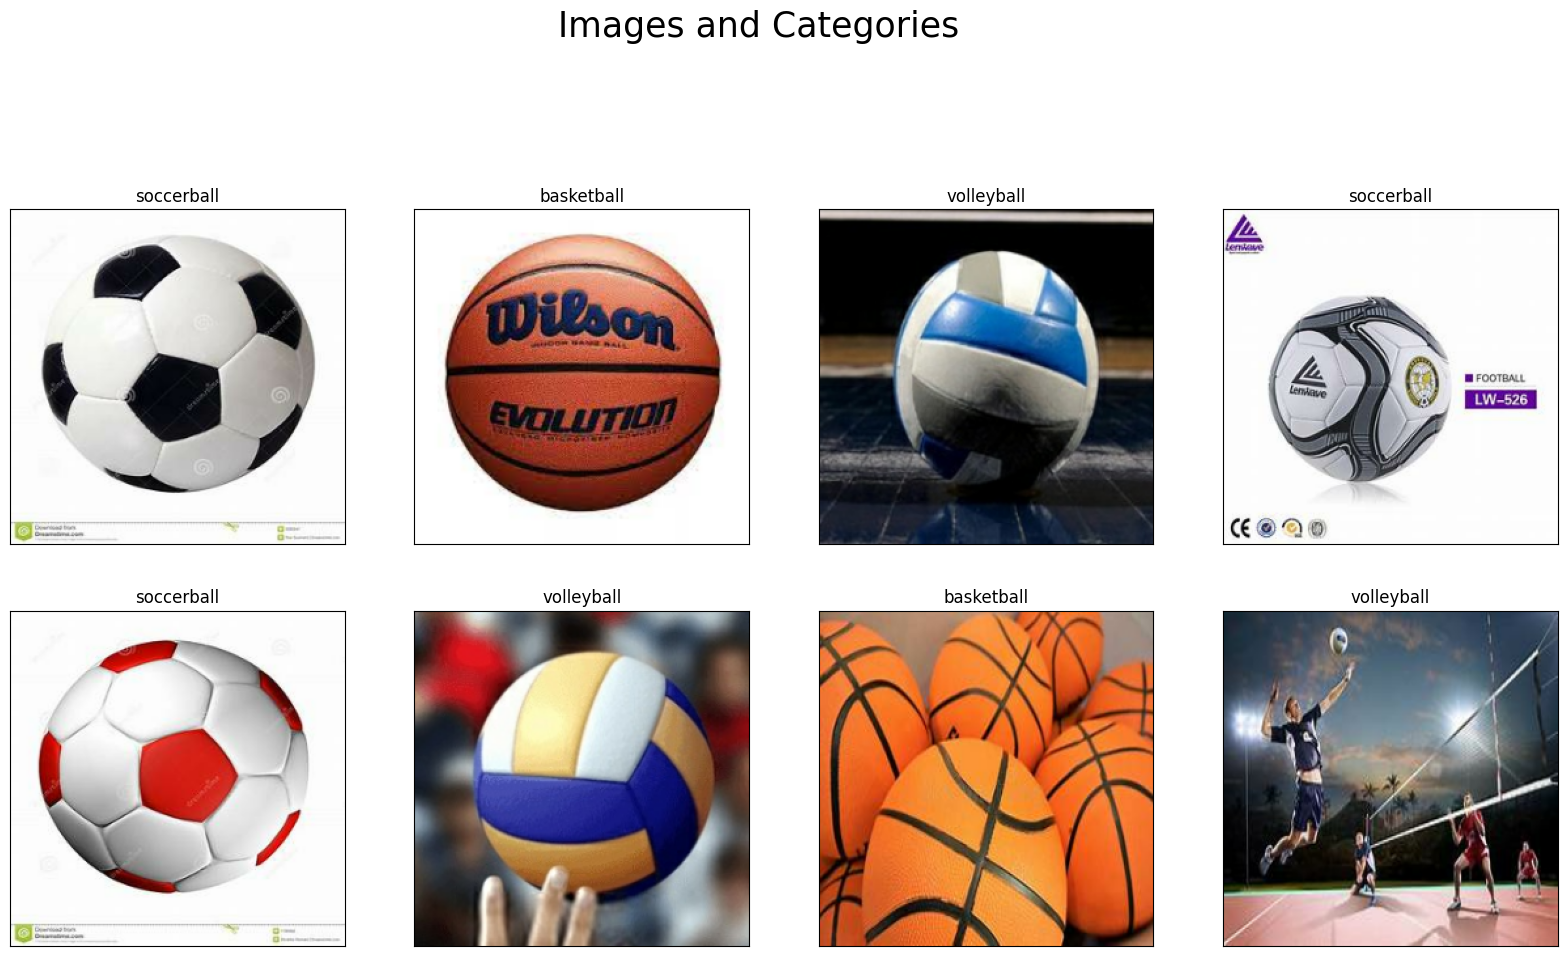

In [393]:
figsize = (20,20)
figure = plt.figure(figsize=figsize)
figure.suptitle("Images and Categories", fontsize=25)

for i in range(8):
    plt.subplot(4,4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.title(class_names[batch[1][i]])
plt.show()    

# 2. Preprocessing Data <a id="preprocess"></a>

* Scale the images values to be between 0-1 by dividing by 255. This helps our deep learning model journalize faster.   
* Split data into 70% training, 20% validation and 10% testing 

## 2.1 Scale Data <a id="scale"></a>

In [399]:
scaled_data = data.map(lambda x, y: (x/255, y))

In [400]:
batch = scaled_data.as_numpy_iterator().next()

# Checking scaling
print(batch[0].min())
print(batch[0].max())

0.0
1.0


## 2.2 Split Data <a id="split"></a>

In [401]:
train_size = int(len(data)*0.7)
validation_size = int(len(data)*0.2) + 1
test_size = int(len(data)*0.1)

print(train_size, validation_size, test_size, len(data))
if(train_size + validation_size + test_size != len(data)):
    print("Data does not add up to", len(data))

156 45 22 223


In [402]:
train = scaled_data.take(train_size)
validation = scaled_data.skip(train_size).take(validation_size)
test = scaled_data.skip(train_size + validation_size).take(test_size)

# 3. Deep Model <a id="deep_model"></a>

## 3.1 Build Deep Learning Model <a id="build_model"></a>

In [403]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [404]:
model = Sequential()

In [405]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names)))

In [406]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [407]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 conv2d_95 (Conv2D)          (None, 252, 252, 16)      2320      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 60, 60, 32)      

## 3.2 Train Model <a id="train"></a>

In [408]:
history = model.fit(train, epochs=15, validation_data=validation)

Epoch 1/15
156/156 [==============================] - 8s 35ms/step - loss: 0.8417 - accuracy: 0.6161 - val_loss: 0.8867 - val_accuracy: 0.6504
Epoch 2/15
156/156 [==============================] - 7s 33ms/step - loss: 0.6464 - accuracy: 0.7235 - val_loss: 0.5401 - val_accuracy: 0.7496
Epoch 3/15
156/156 [==============================] - 7s 34ms/step - loss: 0.5260 - accuracy: 0.7913 - val_loss: 0.3764 - val_accuracy: 0.8474
Epoch 4/15
156/156 [==============================] - 7s 33ms/step - loss: 0.3974 - accuracy: 0.8467 - val_loss: 0.2724 - val_accuracy: 0.8963
Epoch 5/15
156/156 [==============================] - 8s 36ms/step - loss: 0.2976 - accuracy: 0.8905 - val_loss: 0.2411 - val_accuracy: 0.9141
Epoch 6/15
156/156 [==============================] - 7s 34ms/step - loss: 0.1787 - accuracy: 0.9376 - val_loss: 0.1827 - val_accuracy: 0.9481
Epoch 7/15
156/156 [==============================] - 7s 33ms/step - loss: 0.1524 - accuracy: 0.9427 - val_loss: 0.1577 - val_accuracy: 0.9452

## 3.3 Plot Performance <a id="performance"><a/>

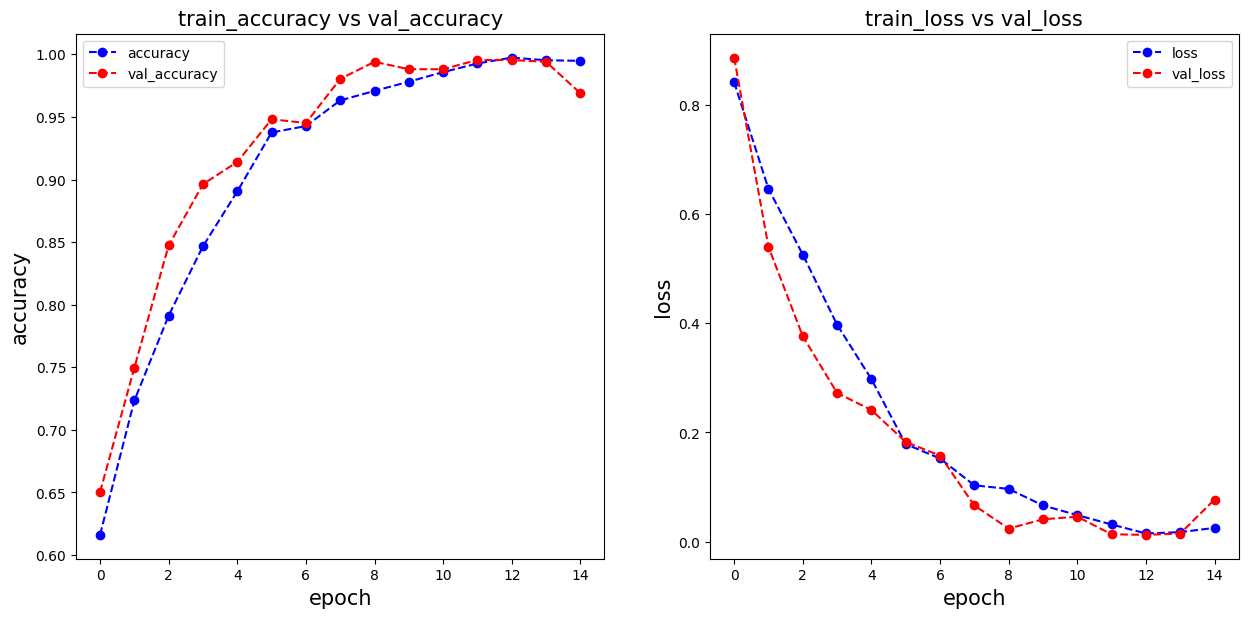

In [409]:
figure = plt.figure(figsize=(15,15))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'ro--', label = 'val_accuracy')
plt.title('train_accuracy vs val_accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label = 'loss')
plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
plt.title('train_loss vs val_loss', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend()

plt.show()

# 4. Evaluate Performance <a id='evaluation'></a>

## 4.1 Evaluate <a id="evaluate"></a>

In [410]:
from sklearn.metrics import classification_report

In [411]:
test_list = []
predict_list = []

In [ ]:
def predictList(batch):
    value_list = []
    
    for i in range(len(batch)):
        score = tf.nn.softmax(batch[i])
        value_list.append(np.argmax(score))
    return value_list

for batch in test.as_numpy_iterator():
    img, val = batch
    
    predict = model.predict(img)
    predict_list = np.append(predict_list, predictList(predict))
    test_list = np.append(test_list, val)

In [413]:
print(classification_report(test_list, predict_list))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       108
         1.0       0.98      0.99      0.98       130
         2.0       0.99      0.96      0.97        92

    accuracy                           0.98       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.98      0.98      0.98       330



## 4.2 Test Multiple Images <a id="test_multi"></a>

Testing images that are harder to classify

In [441]:
testing = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test'))
scaled_test = testing.map(lambda x, y: (x/255, y))

testing_iterator = scaled_test.as_numpy_iterator()
batch = testing_iterator.next()

Found 20 files belonging to 3 classes.


In [442]:
test_category = np.array(os.listdir(os.path.join(data_dir, 'test')))
case_score = batch[1]

test_list = []
predict_list = []

1/1 [==============================] - 0s 14ms/step


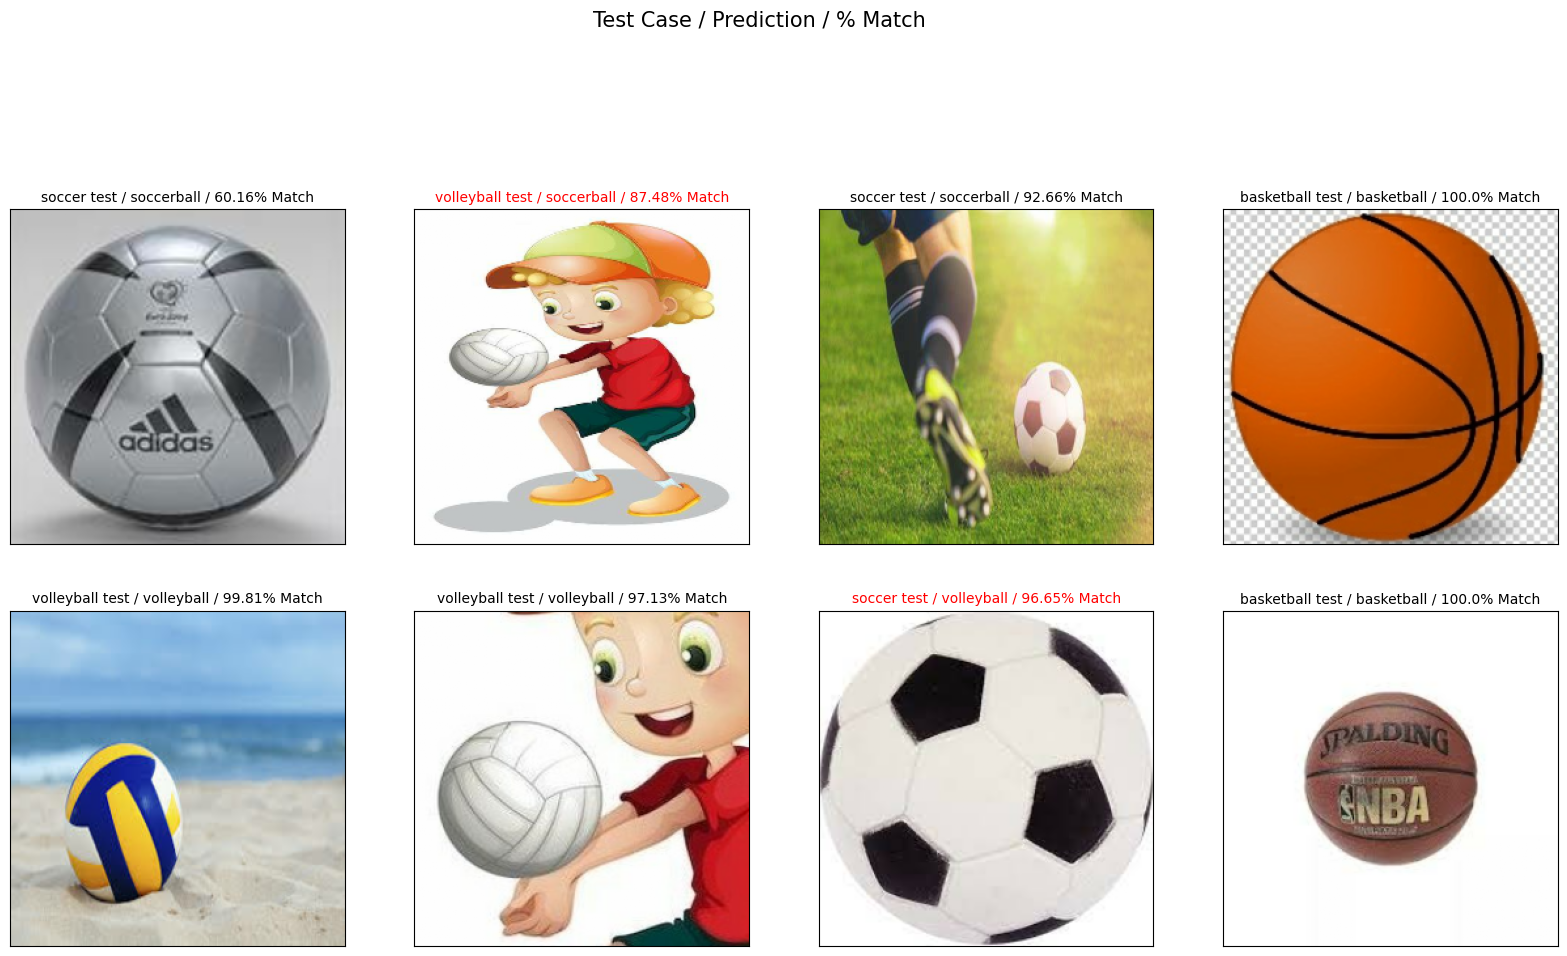

In [444]:
figsize = (20,20)
figure = plt.figure(figsize=figsize)
figure.suptitle("Test Case / Prediction / % Match", fontsize=15)

for i in range(8):
    predict = model.predict(np.expand_dims(batch[0][i], 0))
    score = tf.nn.softmax(predict[0])
    
    test_case = test_category[case_score[i]]
    predict_case = class_names[np.argmax(score)]
    percent_match = round(100*np.max(score), 2)
    font_color = 'black'
    
    if(case_score[i] != np.argmax(score)):
        font_color = 'red'
    
    plt.subplot(4,4, i+1)
    plt.title(f"{test_case} / {predict_case} / {percent_match}% Match", fontsize=10, color=font_color)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(batch[0][i])
    
    test_list = np.append(test_list, case_score[i])
    predict_list = np.append(predict_list, np.argmax(score))

In [417]:
print(classification_report(test_list, predict_list))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       0.50      0.50      0.50         2
         2.0       0.67      0.67      0.67         3

    accuracy                           0.75         8
   macro avg       0.72      0.72      0.72         8
weighted avg       0.75      0.75      0.75         8



## 4.3 Test Single Images <a id="test_single"></a>

In [430]:
test_path = 'soccer test\\soccerball.jpg'
img = cv2.imread(os.path.join('data\\test', test_path))

resize images and setting color to RGB to match the format of our training dataset

In [431]:
resize = tf.image.resize(img, (256, 256))
resize = cv2.cvtColor(resize.numpy(), cv2.COLOR_BGR2RGB)

In [432]:
predict = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 15ms/step


In [433]:
score = tf.nn.softmax(predict[0])
test_case = os.path.dirname(test_path)
predict_case = class_names[np.argmax(score)]
percent_match = round(100 * np.max(score), 2)

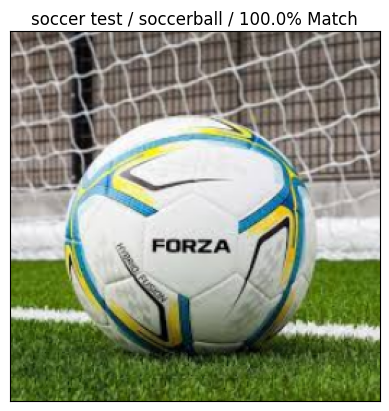

In [434]:
plt.imshow(resize.astype(int))
plt.xticks([])
plt.yticks([])
plt.title(f"{test_case} / {predict_case} / {percent_match}% Match")
plt.show()

# 5. Save Model <a id="saving_model"></a>

In [435]:
from tensorflow.keras.models import load_model

In [436]:
model.save(os.path.join('models', 'imageclassification.h5'))

In [437]:
new_model = load_model('models\\imageclassification.h5')

In [438]:
predict = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 54ms/step


In [439]:
score = tf.nn.softmax(predict[0])
test_case = os.path.dirname(test_path)
predict_case = class_names[np.argmax(score)]
percent_match = round(100 * np.max(score), 2)

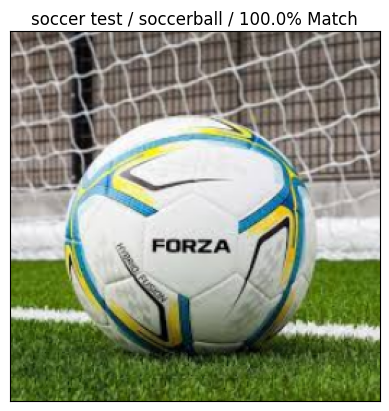

In [440]:
plt.imshow(resize.astype(int))
plt.xticks([])
plt.yticks([])
plt.title(f"{test_case} / {predict_case} / {percent_match}% Match")
plt.show()